In [26]:
import numpy as np
import pandas as pd
import networkx as nx
import re
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
import requests
from fa2 import ForceAtlas2
import community
sns.set()

In [5]:
df = pd.read_csv('characters/chars_data.csv')
df.Name = df.Name.replace(' ', '_', regex=True)
df

,Name,Role,Race,Gender
0,Baddek,Ally,Hylian,Male
1,Bamboo,Ally,Horse,Unknown
2,Banji,Ally,Hylian,Female
3,Baumar,Ally,Hylian,Male
4,Bayge,Ally,Goron,Male
...,...,...,...,...
651,Waterblight_Ganon,Boss,Unknown,Unknown
652,Master_Kohga,Boss,Sheikah,Male
653,Monk_Maz_Koshia,Boss,Sheikah,Male
654,Calamity_Ganon,Boss,Gerudo,Male


In [9]:
for char in df.Name:#df.name:
    address = 'https://zelda.fandom.com/api.php?'
    action="action=query"
    titles=f"titles={char}"
    content="prop=revisions&rvslots=*&rvprop=content"
    dataformat="format=json"
    query = '%s%s&%s&%s&%s' % (address, action, titles, content, dataformat)
    response = requests.get(query)
    content_char = response.text
    with open(f'characters_full/{char}.txt', 'w') as f:
        f.write(content_char)

In [10]:
pattern1 = r'(?<=\[\[).*?(?=\]\])'
pattern2 = r'(?:Term|Plural)[\w\| \(\)\'\\\s\=]*(?=\})'

In [13]:
G = nx.DiGraph()
for index, row in df.iterrows():
    char = row['Name']
    role = row.Role
    if os.path.isfile(f'characters_full/{char}.txt') :
        with open(f'characters_full/{char}.txt') as f:
            
            contents = f.read()
            G.add_node(char, role=row.Role, race=row.Race, gender=row.Gender, loc = len(re.findall(r'\w+', contents)))
            
            links = []
            
            if re.findall(pattern2, contents):
                links += list(set([re.split(r'\|', name)[2] for name in re.findall(pattern2, contents) if len(re.split(r'\|', name)) > 2]))
            links += list(set([re.split(r'\#|\|', name)[0] for name in re.findall(pattern1, contents)]))
            links = [x.replace(" ", "_") for x in links]
            char_links = list(set(links) & set(df.Name))

            for link in char_links:
                G.add_edge(char, link)
            

In [15]:
len(G.nodes)

656

In [16]:
len(G.edges)

2094

In [17]:
largest_cc = max(nx.weakly_connected_components(G), key=len)
DG = G.subgraph(largest_cc)

In [18]:
UD = DG.to_undirected()


In [19]:
d = dict(UD.degree)

In [20]:
mapping = {"Enemy": 'red', "Boss": 'black', "Ally": 'blue'}
colors = [mapping[UD.nodes[n]['role']] for n in UD.nodes()]

In [21]:
edge_colors = [
    "blue" if UD.nodes[edge[0]]['role'] == "Ally" and UD.nodes[edge[1]]['role'] == "Ally" 
    else "red" if UD.nodes[edge[0]]['role'] in ["Enemy", "Boss"] and UD.nodes[edge[1]]['role'] in ["Enemy", "Boss"]
    else "black"
    for edge in UD.edges()
]

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:13<00:00, 147.15it/s]


BarnesHut Approximation  took  1.99  seconds
Repulsion forces  took  10.94  seconds
Gravitational forces  took  0.07  seconds
Attraction forces  took  0.09  seconds
AdjustSpeedAndApplyForces step  took  0.27  seconds


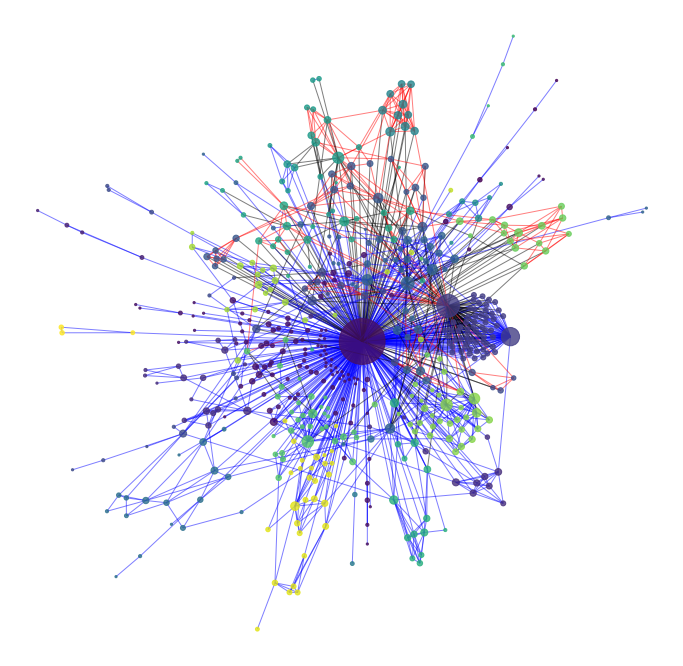

In [52]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.5,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1.0,
                        strongGravityMode=False,
                        gravity=1.5,

                        # Log
                        verbose=True)

plt.figure(figsize=(12,12)) 
positions = forceatlas2.forceatlas2_networkx_layout(UD, pos=None, iterations=2000)
# nx.draw_networkx_nodes(UD, positions, node_size=[v*5 for v in list(d.values())], node_color=colors, alpha=0.8)
nx.draw_networkx_nodes(UD, positions, node_size=[v*5 for v in list(d.values())], cmap=cmap, node_color=list(partition.values()), alpha=0.8)
nx.draw_networkx_edges(UD, positions, edge_color=edge_colors, alpha=0.5)
plt.axis('off')
plt.show()

In [47]:
import community.community_louvain as community_louvain
import matplotlib.cm as cm

In [48]:
partition = community_louvain.best_partition(UD)

In [53]:
len(set(partition.values()))

23

In [58]:
partition

{'Baddek': 0,
 'Savelle': 0,
 'Yammo': 0,
 'Link': 1,
 'Nazbi': 0,
 'Bamboo': 2,
 'Baumar': 2,
 'Banji': 3,
 'Chork': 3,
 'Malanya': 3,
 'Sho': 3,
 'Kenyo': 3,
 'Hylia': 4,
 'Ena': 3,
 'Dabi': 3,
 'Geggle': 3,
 'Konba': 3,
 'Selmie': 2,
 'Falmark': 2,
 'Bayge': 5,
 'Heehl': 5,
 'Kabetta': 5,
 'Daruk': 5,
 'Beedle': 6,
 'Princess_Zelda': 7,
 'Bolson': 8,
 'Boldon': 8,
 'Hudson': 8,
 'Karson': 1,
 'Brigo': 5,
 'Decayed_Guardian': 5,
 'Guardian_Stalker': 5,
 'Cambo': 11,
 'Rik': 11,
 'Chabi': 12,
 'Blue_Bokoblin': 12,
 'Black_Bokoblin': 12,
 'Kilton': 13,
 'Bokoblin': 12,
 'Kass': 14,
 'Chumin': 15,
 'Spinch_(Hylian)': 15,
 'Letty': 15,
 'Epona': 3,
 'Yunobo': 5,
 'Calamity_Ganon': 4,
 'King_Rhoam': 7,
 'Fireblight_Ganon': 5,
 'Bludo': 5,
 'Dark_Beast_Ganon': 5,
 'Revali': 14,
 'Dauntless': 0,
 'Dinraal': 16,
 'Farosh': 16,
 'Naydra': 16,
 'Hestu': 3,
 'Endai': 17,
 'Spoone': 17,
 'Chuchu': 17,
 'Master_Kohga': 7,
 'Fyson': 8,
 'Misa': 8,
 'Rhondson': 8,
 'Greyson': 8,
 'Bohrin': 8,
 'Pel

In [59]:
nx.set_node_attributes(UD, partition, "partition")

In [ ]:
[node for node in UD.nodes if DG.nodes[node]['partition'] == 1]

In [56]:
partition.values()

dict_values([0, 0, 0, 1, 0, 2, 2, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 2, 2, 5, 5, 5, 5, 6, 7, 8, 8, 8, 1, 5, 5, 5, 11, 11, 12, 12, 12, 13, 12, 14, 15, 15, 15, 3, 5, 4, 7, 5, 5, 5, 14, 0, 16, 16, 16, 3, 17, 17, 17, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 8, 18, 1, 14, 14, 14, 14, 14, 14, 13, 7, 6, 12, 12, 18, 18, 18, 18, 1, 1, 18, 18, 18, 6, 18, 1, 1, 1, 7, 7, 11, 11, 7, 7, 7, 7, 16, 21, 1, 8, 1, 3, 3, 3, 3, 3, 4, 4, 13, 13, 6, 6, 4, 4, 7, 7, 7, 8, 8, 4, 4, 7, 7, 7, 7, 7, 7, 4, 1, 4, 17, 17, 4, 4, 4, 4, 1, 1, 3, 3, 3, 3, 3, 4, 6, 6, 6, 6, 17, 13, 4, 4, 4, 4, 1, 4, 4, 4, 6, 5, 3, 3, 3, 3, 1, 1, 5, 5, 18, 5, 5, 5, 1, 1, 1, 1, 4, 1, 8, 8, 5, 13, 13, 13, 13, 5, 5, 5, 8, 1, 1, 1, 1, 4, 4, 4, 4, 3, 1, 1, 20, 20, 1, 1, 20, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 16, 16, 21, 16, 16, 1, 1, 1, 1, 1, 16, 21, 1, 1, 1, 1, 1, 1, 4, 12, 12, 4, 1, 4, 1, 4, 16, 16, 4, 16, 16, 7, 7, 16, 16, 16, 4, 7, 7, 7, 4, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 16, 16, 16, 16, 16, 16, 21, 21, 21, 21, 21, 21, 21, 21, 1, 1, 1, 1, 21, 

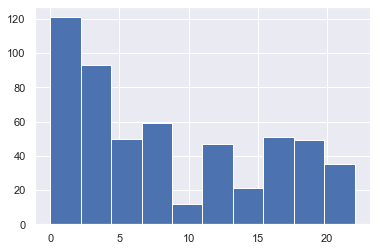

In [61]:
plt.hist(partition.values())
plt.show()

In [51]:
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(UD, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(UD, pos, alpha=0.5)
plt.show()

NameError: name 'pos' is not defined

In [40]:
partition = community.best_partition

AttributeError: module 'community' has no attribute 'best_partition'